In [2]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
%load_ext autoreload
from JKBio.Helper import *
%autoreload 2
%load_ext rpy2.ipython
import numpy as np
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from JKBio.helper import pyDESeq2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

Loading BokehJS ...

downloading their data

# we first need to recreate out RNA matrix from slamdunk's tcount files

In [9]:
ls ../../data/slam/resIRF2BP2/count

mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1.fq_slamdunk_mapped_filtered_tcount.log
mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1.fq_slamdunk_mapped_filtered_tcount_mins.bedgraph
mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1.fq_slamdunk_mapped_filtered_tcount_plus.bedgraph
mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv
mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1.fq_slamdunk_mapped_filtered_tcount.log
mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1.fq_slamdunk_mapped_filtered_tcount_mins.bedgraph
mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1.fq_slamdunk_mapped_filtered_tcount_plus.bedgraph
mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv
mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1.fq_slamdunk_mapped_filtered_tcount.log
mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1.fq_slamdunk_mapped_filtered_tcount_mins.bedgraph
mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1.fq_slamdunk_mapped_filtered_tcount_plus.bedgraph
mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv
mr77-MV411_IRF2B

In [35]:
location= '../../data/slam/IRF2BP2degraded_v1/count/'

In [36]:
files = ! ls $location*.tsv
files

['../../data/slam/IRF2BP2degraded_v1/count/mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP2degraded_v1/count/mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP2degraded_v1/count/mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP2degraded_v1/count/mr77-MV411_IRF2BP2-DMSO_2h-r4_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP2degraded_v1/count/mr78-MV411_IRF2BP2-DMSO_6h-r1_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP2degraded_v1/count/mr79-MV411_IRF2BP2-DMSO_6h-r2_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP2degraded_v1/count/mr80-MV411_IRF2BP2-DMSO_6h-r3_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP2degraded_v1/count/mr81-MV411_IRF2BP2-DMSO_6h-r4_1_val_1.fq_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/IRF2BP

In [37]:
data={}
for file in files:
    data[file.split('.')[-3].split('/')[-1]]= pd.read_csv(file, sep='\t', comment='#',header=0)

In [38]:
prev = -2
for k,val in data.items():
    if len(set(val.Name)) != prev and prev!=-2: 
        raise ValueError('we do not have the same number of genes in each file')
    prev = len(set(val.Name))

![](images/conversionrates.png)

In [39]:
data.keys()

dict_keys(['mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1', 'mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1', 'mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1', 'mr77-MV411_IRF2BP2-DMSO_2h-r4_1_val_1', 'mr78-MV411_IRF2BP2-DMSO_6h-r1_1_val_1', 'mr79-MV411_IRF2BP2-DMSO_6h-r2_1_val_1', 'mr80-MV411_IRF2BP2-DMSO_6h-r3_1_val_1', 'mr81-MV411_IRF2BP2-DMSO_6h-r4_1_val_1', 'mr82-MV411_IRF2BP2-VHL_2h-r1_1_val_1', 'mr83-MV411_IRF2BP2-VHL_2h-r2_1_val_1', 'mr84-MV411_IRF2BP2-VHL_2h-r3_1_val_1', 'mr85-MV411_IRF2BP2-VHL_2h-r4_1_val_1', 'mr86-MV411_IRF2BP2-VHL_6h-r1_1_val_1', 'mr87-MV411_IRF2BP2-VHL_6h-r2_1_val_1', 'mr88-MV411_IRF2BP2-VHL_6h-r3_1_val_1', 'mr89-MV411_IRF2BP2-VHL_6h-r4_1_val_1'])

In [40]:
val

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
0,chr22,29442122,29442455,5988,333,+,0.000000,0.000000,112,0,0,0,0,0,-1.0,-1.0
1,chr19,13961529,13962694,5989,1165,-,0.000000,1.469883,242,807,0,80,0,0,-1.0,-1.0
2,chr12,109448654,109451813,83892,3159,-,0.000245,13.633161,921,8175,2,742,1,0,-1.0,-1.0
3,chr12,109456117,109456313,83892,196,-,0.000000,1.157533,57,655,0,63,0,0,-1.0,-1.0
4,chr12,109457629,109457682,83892,53,-,0.000000,0.753315,10,216,0,41,0,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58131,chr1,46691873,46692098,100130197,225,+,0.000000,1.157533,61,520,0,63,0,0,-1.0,-1.0
58132,chr2,101151659,101152759,100506286,1100,+,0.000000,0.036747,191,14,0,2,0,0,-1.0,-1.0
58133,chr2,101154034,101155412,100506286,1378,+,0.000000,0.055121,337,26,0,3,0,0,-1.0,-1.0
58134,chrX,106639813,106639896,100616144,83,+,0.000000,0.000000,25,0,0,0,0,0,-1.0,-1.0


In [41]:
flag_var= 100

readcounts = {i:[0]*len(data) for i in val.Name.unique()}
tccounts = {i:[0]*len(data) for i in val.Name.unique()}

In [42]:
for n, (_,val) in enumerate(data.items()):
    val = val.sort_values(by="Name")
    j  = 0
    #print('              ',end='\r')
    readcount = [val.iloc[0].ReadCount]
    tccount = [val.iloc[0].TcReadCount]
    prevname = val.iloc[0].Name
    for _, v in val.iloc[1:].iterrows():
        if v.Name==4609:
            print(v.ReadCount,v.TcReadCount)
            print(readcount,tccount)
        if v.Name == prevname:
            readcount.append(v.ReadCount)
            tccount.append(v.TcReadCount)
        else:
            readcounts[prevname][n] = np.sum(readcount)
            tccounts[prevname][n] = np.sum(tccount)
            #if np.var(readcount) > flag_var:
            #    print("pb with "+str(v.Name))
            prevname=v.Name
            j+=1
            #print(j,end='\r')
            readcount = [v.ReadCount]
            tccount = [v.TcReadCount]
            
files = [*data]

962 7
[167, 41] [0, 0]
858 2
[303, 81] [0, 0]
261 0
[244, 1] [0, 0]
1157 1
[376, 67] [0, 0]
1195 7
[226, 58] [0, 0]
1858 3
[614, 146] [0, 0]
1827 10
[426, 105] [0, 0]
1673 2
[456, 155] [0, 0]
2012 3
[298, 74] [0, 0]
1823 4
[377, 127] [0, 0]
1360 7
[193, 24] [0, 0]
1777 7
[415, 82] [0, 0]
1467 0
[238, 53] [0, 0]
1161 3
[359, 85] [0, 0]
1221 4
[252, 65] [0, 0]
853 4
[407, 36] [0, 0]


In [43]:
val.Name

35944            1
14222            2
42459            3
42460            3
42452            3
           ...    
33888    107282092
8628     107303344
7168     107397392
43745    107399301
43744    107399303
Name: Name, Length: 58136, dtype: int64

In [44]:
readcounts = pd.DataFrame(data=readcounts,columns=val.Name.unique(),index=data.keys()).T
tccounts = pd.DataFrame(data=tccounts,columns=val.Name.unique(),index=data.keys()).T

In [45]:
names, _ = convertGenes(readcounts.index.tolist(), from_idtype="entrez_id", to_idtype="symbol")
readcounts.index = names

you need access to taiga for this (https://pypi.org/project/taigapy/)
1118 could not be parsed... we don't have all genes already


In [46]:
names, _ = convertGenes(tccounts.index.tolist(), from_idtype="entrez_id", to_idtype="symbol")
tccounts.index = names

you need access to taiga for this (https://pypi.org/project/taigapy/)
1118 could not be parsed... we don't have all genes already


In [47]:
todrop=np.argwhere(tccounts.values.max(1)>=2).ravel()
tccounts = tccounts.iloc[todrop]
readcounts = readcounts.iloc[todrop]

In [48]:
todrop=np.argwhere(readcounts.values.max(1)>=10).ravel()
tccounts = tccounts.iloc[todrop]
readcounts = readcounts.iloc[todrop]

In [27]:
len(readcounts)

4262

## SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

0.06724463
0.04916348
0.03728357
0.05075007
0.03331248
0.0346662
0.03265504 
0.04416262
0.05574821
0.05845953
0.05531433
0.06175393
0.03181749 
0.02940226 
0.0306263
0.04004278

In [49]:
tccounts

,mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1,mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1,mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1,mr77-MV411_IRF2BP2-DMSO_2h-r4_1_val_1,mr78-MV411_IRF2BP2-DMSO_6h-r1_1_val_1,mr79-MV411_IRF2BP2-DMSO_6h-r2_1_val_1,mr80-MV411_IRF2BP2-DMSO_6h-r3_1_val_1,mr81-MV411_IRF2BP2-DMSO_6h-r4_1_val_1,mr82-MV411_IRF2BP2-VHL_2h-r1_1_val_1,mr83-MV411_IRF2BP2-VHL_2h-r2_1_val_1,mr84-MV411_IRF2BP2-VHL_2h-r3_1_val_1,mr85-MV411_IRF2BP2-VHL_2h-r4_1_val_1,mr86-MV411_IRF2BP2-VHL_6h-r1_1_val_1,mr87-MV411_IRF2BP2-VHL_6h-r2_1_val_1,mr88-MV411_IRF2BP2-VHL_6h-r3_1_val_1,mr89-MV411_IRF2BP2-VHL_6h-r4_1_val_1
ABL1,1,1,0,0,0,0,0,1,1,2,0,0,0,0,0,0
ABR,3,2,4,1,0,2,2,3,9,3,1,3,0,0,1,1
ACAT2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
ACLY,3,0,0,0,0,1,0,2,0,2,0,0,0,1,0,0
ACTB,0,1,0,9,0,6,1,4,6,7,3,13,1,7,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105369438,0,1,0,0,2,1,0,0,0,0,0,2,0,1,1,1
SNORA103,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
SNORD141A,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
SNORD141B,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0


In [135]:
pd.DataFrame(tccounts.values[:,:-1].astype(float)/readcounts.mean().values*100, columns=tccounts.columns[:-1], index=tccounts['genes']).to_csv('ratio')

In [152]:
(tccounts.values[:,:-1].astype(float)/(1+readcounts.values[:,:-1].astype(float))).mean(0)

array([0.06724463, 0.04916348, 0.03728357, 0.05075007, 0.03331248,
       0.0346662 , 0.03265504, 0.04416262, 0.05574821, 0.05845953,
       0.05531433, 0.06175393, 0.03181749, 0.02940226, 0.0306263 ,
       0.04004278])

In [146]:
ratio.mean()

mr74-MV411_IRF2BP2-DMSO_2h-r1    4.900631
mr75-MV411_IRF2BP2-DMSO_2h-r2    3.369334
mr76-MV411_IRF2BP2-DMSO_2h-r3    2.658658
mr77-MV411_IRF2BP2-DMSO_2h-r4    3.251876
mr78-MV411_IRF2BP2-DMSO_6h-r1    2.336209
mr79-MV411_IRF2BP2-DMSO_6h-r2    2.420170
mr80-MV411_IRF2BP2-DMSO_6h-r3    2.241392
mr81-MV411_IRF2BP2-DMSO_6h-r4    2.990919
mr82-MV411_IRF2BP2-VHL_2h-r1     3.714161
mr83-MV411_IRF2BP2-VHL_2h-r2     3.839315
mr84-MV411_IRF2BP2-VHL_2h-r3     3.808982
mr85-MV411_IRF2BP2-VHL_2h-r4     3.796861
mr86-MV411_IRF2BP2-VHL_6h-r1     2.214244
mr87-MV411_IRF2BP2-VHL_6h-r2     2.068752
mr88-MV411_IRF2BP2-VHL_6h-r3     2.123984
mr89-MV411_IRF2BP2-VHL_6h-r4     2.583305
dtype: float64

In [197]:
ls ..

data/       GSEA_/           nextflow/   pipeline.md  requirements.txt  temp/
documents/  html_notebooks/  notebooks/  README.md    results/


In [50]:
tccounts.mean()

mr74-MV411_IRF2BP2-DMSO_2h-r1_1_val_1    0.463397
mr75-MV411_IRF2BP2-DMSO_2h-r2_1_val_1    0.360394
mr76-MV411_IRF2BP2-DMSO_2h-r3_1_val_1    0.368372
mr77-MV411_IRF2BP2-DMSO_2h-r4_1_val_1    0.494838
mr78-MV411_IRF2BP2-DMSO_6h-r1_1_val_1    0.348897
mr79-MV411_IRF2BP2-DMSO_6h-r2_1_val_1    0.669639
mr80-MV411_IRF2BP2-DMSO_6h-r3_1_val_1    0.475598
mr81-MV411_IRF2BP2-DMSO_6h-r4_1_val_1    0.650399
mr82-MV411_IRF2BP2-VHL_2h-r1_1_val_1     0.984514
mr83-MV411_IRF2BP2-VHL_2h-r2_1_val_1     1.084467
mr84-MV411_IRF2BP2-VHL_2h-r3_1_val_1     0.754341
mr85-MV411_IRF2BP2-VHL_2h-r4_1_val_1     1.183247
mr86-MV411_IRF2BP2-VHL_6h-r1_1_val_1     0.460347
mr87-MV411_IRF2BP2-VHL_6h-r2_1_val_1     0.398405
mr88-MV411_IRF2BP2-VHL_6h-r3_1_val_1     0.447443
mr89-MV411_IRF2BP2-VHL_6h-r4_1_val_1     0.714219
dtype: float64

In [192]:
readcounts.to_csv('readcounts.csv',index=False)

# lets look at the similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [ ]:
counts.loc['MYC']

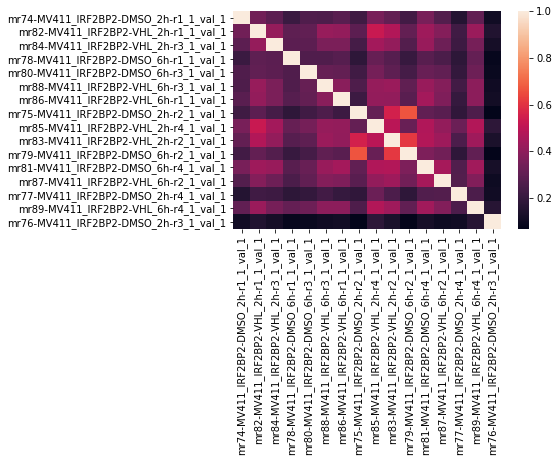

In [52]:
%matplotlib inline
sort = [0,8,10,4,6,14,12,1,11,9,5,7,13,3,15,2]
sns.heatmap(tccounts[tccounts.columns[sort]].corr(), 
            xticklabels=tccounts.columns[sort].values,
            yticklabels=tccounts.columns[sort].values)

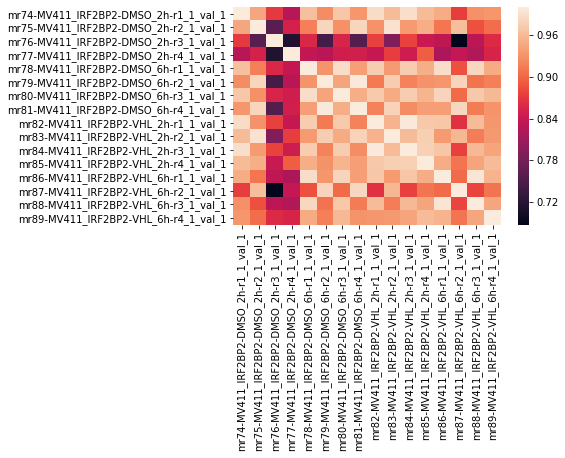

In [53]:
%matplotlib inline
sns.heatmap(readcounts.corr(), 
            xticklabels=readcounts.columns,
            yticklabels=readcounts.columns)

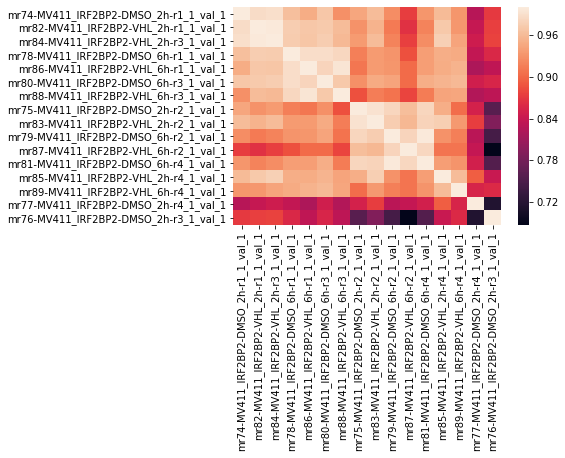

In [54]:
%matplotlib inline
sort = [0,8,10,4,12,6,14,1,9,5,13,7,11,15,3,2]
sns.heatmap(readcounts[readcounts.columns[sort]].corr(), 
            xticklabels=readcounts.columns.values[sort],
            yticklabels=readcounts.columns.values[sort])

read the paper for MV411 QC steps.

### A quick detour to look for clustering

## Getting the Core TF information

In [290]:
cd ../../../AMLproject/notebooks

/home/jeremie/AMLproject


In [295]:
ctf=pd.read_csv('../data/CTF.csv',header=None)[0].values.tolist()
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'IKAROS',
 'GFI1',
 'LMO2',
 'CEBPA',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

In [296]:
set(ctf) & set(tccounts.index)

set()

In [72]:
ctfpos = [val for val in tccounts.index if val in ctf]
notctfpos = [val for val in tccounts.index if val not in ctf]

In [ ]:
ctfpos.extend(['EGR1','SERTAD1'])

We find a CTF not in the dataset

# Let's look at how they change accross time

how core transcription factors change accross time when the cell is with JQ1 conditions

we are looking at the difference between production of each CTF compared to the average RNA production with JQ1 and without JQ1

## DESEQ ANALYSIS

In [73]:
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)
tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [74]:
tccounts.iloc[140]

mr74-MV411_IRF2BP2-DMSO_2h-r1         12
mr75-MV411_IRF2BP2-DMSO_2h-r2         35
mr76-MV411_IRF2BP2-DMSO_2h-r3          0
mr77-MV411_IRF2BP2-DMSO_2h-r4          6
mr78-MV411_IRF2BP2-DMSO_6h-r1         16
mr79-MV411_IRF2BP2-DMSO_6h-r2         30
mr80-MV411_IRF2BP2-DMSO_6h-r3         28
mr81-MV411_IRF2BP2-DMSO_6h-r4         61
mr82-MV411_IRF2BP2-VHL_2h-r1          37
mr83-MV411_IRF2BP2-VHL_2h-r2          28
mr84-MV411_IRF2BP2-VHL_2h-r3          33
mr85-MV411_IRF2BP2-VHL_2h-r4          72
mr86-MV411_IRF2BP2-VHL_6h-r1           5
mr87-MV411_IRF2BP2-VHL_6h-r2          16
mr88-MV411_IRF2BP2-VHL_6h-r3          12
mr89-MV411_IRF2BP2-VHL_6h-r4           8
genes                            DNAJC11
Name: 140, dtype: object

In [147]:
tccounts.columns

Index(['mr74-MV411_IRF2BP2-DMSO_2h-r1', 'mr75-MV411_IRF2BP2-DMSO_2h-r2',
       'mr76-MV411_IRF2BP2-DMSO_2h-r3', 'mr77-MV411_IRF2BP2-DMSO_2h-r4',
       'mr78-MV411_IRF2BP2-DMSO_6h-r1', 'mr79-MV411_IRF2BP2-DMSO_6h-r2',
       'mr80-MV411_IRF2BP2-DMSO_6h-r3', 'mr81-MV411_IRF2BP2-DMSO_6h-r4',
       'mr82-MV411_IRF2BP2-VHL_2h-r1', 'mr83-MV411_IRF2BP2-VHL_2h-r2',
       'mr84-MV411_IRF2BP2-VHL_2h-r3', 'mr85-MV411_IRF2BP2-VHL_2h-r4',
       'mr86-MV411_IRF2BP2-VHL_6h-r1', 'mr87-MV411_IRF2BP2-VHL_6h-r2',
       'mr88-MV411_IRF2BP2-VHL_6h-r3', 'mr89-MV411_IRF2BP2-VHL_6h-r4',
       'genes'],
      dtype='object')

In [258]:
design = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['VHL','DMSO'], 
                      data=np.array([[1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
                                     [0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0]],dtype=bool).T)

In [257]:
design_reg = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','VHL'], 
                      data=np.array([[0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]],dtype=bool).T)

In [209]:
designoto = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','VHL'], 
                      data=np.array([[1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0]],dtype=bool).T)

### Differential gene expression analysis, PCA and GO-term enrichment

For gene-level analysis, raw reads mapped to different UTR annotations of the same gene were summed up by Entrez Gene ID. Pilot studies of K562 cells with kinase inhibitors were performed as single experiments. 

Analysis of differential gene expression was restricted to genes with ≥ 10 reads in at least one condition for 50bp sequencing runs (flavopiridol and DMSO) or ≥ 20 reads in at least one condition for 100bp sequencing runs (mk2206, trametinib, nilotinib, trametinib + mk2206 and DMSO). For estimating differential expression, a pseudo-count of 1 raw read was added to all genes.

#### All other SLAM-seq experiments were performed in triplicates and analyzed as follows. 
Differential gene expression calling was performed on raw read counts with ≥ 2 T>C conversions using DESeq2 (version 1.14.1) with default settings, and with size factors estimated on corresponding total mRNA reads for global normalization.

Downstream analysis was restricted to genes passing all internal filters for FDR estimation by DESeq2. Principal component analysis was performed after variance
stabilizing transformation on the 500 most variable genes across all conditions of a given
experiment. GO-term enrichment analysis was performed on genes significantly and strongly downregulated (FDR ≤ 0.1, log2FC ≤ -1) in SLAM-seq upon IAA-treatment in K562MYC-AID + Tir1 by the PANTHER Overrepresentation Test (Fisher's Exact with FDR multiple test correction, release 20171205, http://pantherdb.org) on GO Ontology database Released 2017-12-27.

In [259]:
design

,VHL,DMSO
mr74.MV411_IRF2BP2.DMSO_2h.r1,True,False
mr75.MV411_IRF2BP2.DMSO_2h.r2,False,False
mr76.MV411_IRF2BP2.DMSO_2h.r3,False,False
mr77.MV411_IRF2BP2.DMSO_2h.r4,False,False
mr78.MV411_IRF2BP2.DMSO_6h.r1,False,True
mr79.MV411_IRF2BP2.DMSO_6h.r2,False,True
mr80.MV411_IRF2BP2.DMSO_6h.r3,False,True
mr81.MV411_IRF2BP2.DMSO_6h.r4,False,False
mr82.MV411_IRF2BP2.VHL_2h.r1,True,False
mr83.MV411_IRF2BP2.VHL_2h.r2,True,False


In [260]:
tccounts.columns = [i.replace('-','.') for i in tccounts.columns]

In [261]:
tccounts[tccounts.genes=='MYC']

,mr74.MV411_IRF2BP2.DMSO_2h.r1,mr75.MV411_IRF2BP2.DMSO_2h.r2,mr76.MV411_IRF2BP2.DMSO_2h.r3,mr77.MV411_IRF2BP2.DMSO_2h.r4,mr78.MV411_IRF2BP2.DMSO_6h.r1,mr79.MV411_IRF2BP2.DMSO_6h.r2,mr80.MV411_IRF2BP2.DMSO_6h.r3,mr81.MV411_IRF2BP2.DMSO_6h.r4,mr82.MV411_IRF2BP2.VHL_2h.r1,mr83.MV411_IRF2BP2.VHL_2h.r2,mr84.MV411_IRF2BP2.VHL_2h.r3,mr85.MV411_IRF2BP2.VHL_2h.r4,mr86.MV411_IRF2BP2.VHL_6h.r1,mr87.MV411_IRF2BP2.VHL_6h.r2,mr88.MV411_IRF2BP2.VHL_6h.r3,mr89.MV411_IRF2BP2.VHL_6h.r4,genes
5388,1303,908,148,1349,839,1444,1489,1709,2186,2270,1654,2438,1137,752,970,784,MYC


In [262]:
deseq = pyDESeq2.pyDESeq2(count_matrix=tccounts[tccounts.columns[np.array([1,0,0,0,1,1,1,0,1,1,1,0,0,1,0,0,1],np.bool)]],
                         design_matrix=design[np.array([1,0,0,0,1,1,1,0,1,1,1,0,0,1,0,0],np.bool)],
                         design_formula="~DMSO - VHL",
                         gene_column="genes")

3.2.6


In [222]:
deseq = pyDESeq2.pyDESeq2(count_matrix=tccounts[tccounts.columns[np.array([0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1],np.bool)]],
                         design_matrix=design_reg[np.array([0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],np.bool)],
                         design_formula="~DMSO - VHL",
                         gene_column="genes")

3.2.6


In [210]:
deseq = pyDESeq2.pyDESeq2(count_matrix=tccounts[tccounts.columns[np.array([1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1],np.bool)]],
                         design_matrix=designoto[np.array([1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0],np.bool)],
                         design_formula="~DMSO - VHL",
                         gene_column="genes")

3.2.6


In [200]:
np.exp(np.mean(np.log(readcounts[readcounts.columns[np.array(
    [1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],np.bool)]].values+1), 1))

array([ 149.31510305,  269.33250825,  690.84296334, ..., 2190.49994294,
          4.89897949,  235.8262072 ])

In [263]:
deseq.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[
        np.array([1,0,0,0,1,1,1,0,1,1,1,0,0,1,0,0,0],np.bool)]].values+1), 1)))

In [223]:
deseq.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[
        np.array([0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0],np.bool)]].values+1), 1)))

In [211]:
deseq.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[
        np.array([1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0],np.bool)]].values+1), 1)))

In [264]:
deseq.run_deseq()

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [265]:
deseq.get_deseq_result()

In [266]:
JQ1res = deseq.deseq_result

In [267]:
JQ1res.pvalue = np.nan_to_num(np.array(JQ1res.pvalue), 1)
JQ1res.log2FoldChange = np.nan_to_num(np.array(JQ1res.log2FoldChange), 0)

In [268]:
JQ1res[JQ1res.genes=='MYC']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes
5388,1407.651552,-0.115961,0.182388,-0.635793,0.524912,0.852845,MYC


In [ ]:
JQ1res.to_csv("data/jq1.mv411.csv")

In [269]:
JQ1res.log2FoldChange = -JQ1res.log2FoldChange

In [270]:
JQ1res["gene_id"] = JQ1res.genes

In [244]:
JQ1res[JQ1res.gene_id=='HNRNPA1']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
5170,395.420935,-0.299414,0.166121,1.802386,0.071485,0.449651,HNRNPA1,HNRNPA1


In [271]:
show(volcano(JQ1res,tohighlight=ctf, searchbox=True))

we can conclude that we get similar results to the slamseq myc paper although it seems that our values are a bit skewed toward higher expression than what is on the slamseq paper. It mightt be explained by the pseudo count of 1 that I did not set. Because I think it would highly bias the DESeq algorithm.